In [23]:
# Set dates of baseline and follow-up periods
d4 = '2019-03-01' # month after end of follow-up period
d3 = '2018-01-01' # follow-up start
d2 = '2018-01-01' # month after end of baseline period
d1 = '2017-09-01' # baseline start


# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_cephalosporins
WHERE EXTRACT (YEAR from month)  >= 2017
'''
df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
df1["month"] = pd.to_datetime(df1.month)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114632 entries, 0 to 114631
Data columns (total 8 columns):
numerator      114632 non-null int32
denominator    114632 non-null int32
practice_id    114632 non-null object
pct_id         114632 non-null object
month          114632 non-null datetime64[ns]
calc_value     103487 non-null float64
percentile     103487 non-null float64
month_no       114632 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(3), object(2)
memory usage: 5.7+ MB


In [24]:
### select data only for the baseline and follow-up periods
import datetime

conditions = [
    (df1['month']  >= d4), # after follow-up period
    (df1['month']  >= d3), # follow-up
    (df1['month']  >= d2), # mid
    (df1['month']  >= d1), # baseline
    (df1['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
df1['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
df2 = df1[["practice_id","period", "month", "numerator","denominator"]]
df2 = df2.set_index(["practice_id","period", "month"])
df2

,,,numerator,denominator
practice_id,period,month,,
A84618,baseline,2017-09-01,0,0
C81665,baseline,2017-09-01,0,0
C84146,baseline,2017-09-01,0,0
D83620,baseline,2017-09-01,0,0
F86686,baseline,2017-09-01,0,0
G81661,baseline,2017-09-01,0,0
G82769,baseline,2017-09-01,0,0
J82191,baseline,2017-09-01,0,0
K84022,baseline,2017-09-01,0,0


In [25]:

dfm = df2.reset_index()
dfm = dfm.loc[(dfm.period=="baseline") | (dfm.period=="follow-up")]

### sum numerator and denominators for each practice for each period
agg_6m = dfm.groupby(["practice_id","period"]).sum()

### calculate aggregated measure values
agg_6m["calc_value"] = agg_6m.numerator / agg_6m.denominator

# unstack years
dfx = agg_6m.reset_index()
dfx = dfx[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dfx = dfx.unstack(1)

# rename columns appropriately
dfx.columns = dfx.columns.droplevel()
dfx.columns.values[0] = 'Baseline Measure'
dfx.columns.values[1] = 'Follow-up Measure'
dfx.columns.values[2] = 'Baseline Items'
dfx.columns.values[3] = 'Follow-up Items'
dfx.columns.values[4] = 'Baseline Denominator'
dfx.columns.values[5] = 'Follow-up Denominator'

dfx

period,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
practice_id,,,,,,
A81001,0.047454,0.044990,41,22,864,489
A81002,0.089799,0.077411,397,183,4421,2364
A81003,NaN,NaN,0,0,0,0
A81004,0.085055,0.074312,177,81,2081,1090
A81005,0.107050,0.115594,164,106,1532,917
A81006,0.074603,0.087538,230,144,3083,1645
A81007,0.071429,0.049652,130,50,1820,1007
A81008,NaN,NaN,0,0,0,0
A81009,0.081767,0.074795,161,73,1969,976


In [26]:
### import **allocated** practices
prac = pd.read_csv('allocated_practices_cephalosporin_test2.csv', usecols=["practice_id","ccg_id","allocation","group_ab"])
dfx2 = dfx.reset_index()

dfx2 = prac.merge(dfx2, how='left', on='practice_id')

# count how many practices have no data for follow-up period

print (dfx2.loc[pd.isnull(dfx2["Follow-up Measure"])].shape[0], "of", dfx2.shape[0], "allocated practices have no follow-up data.")

0 of 1405 allocated practices have no follow-up data.


C:\Users\hcurtis\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


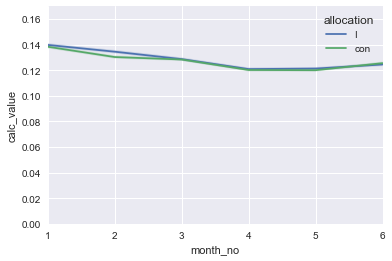

In [37]:
# plot time series chart for intervention versus control

# merge MONTHLY data with practice allocations 
dfp = df1.loc[df1.month_no>0]
dfp = dfp.loc[~pd.isnull(dfp.calc_value)]
dfp = prac.merge(dfp, how='left', on='practice_id')#.set_index('allocation')
dfp = dfp[['practice_id','month_no','allocation','calc_value']]

dfp2 = dfp.groupby(['month_no','allocation']).count()
#dfp = pd.DataFrame(dfp.to_records())#.set_index('month_no')
dfp2

import seaborn as sns#; sns.set(color_codes=True)
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

g = sns.tsplot(data=dfp, time="month_no",  value="calc_value", unit="practice_id",condition="allocation")
plt.ylim((0, 0.17))
plt.show()


In [35]:
'''## Regression using sklearn module
import sklearn
print sklearn.feature_selection.f_regression(X, y, center=True)

data = dfr
# regression using scikit
# create a new Series called intervention
data['intervention'] = data.allocation.map({'con':0, 'I':1})
# create X and y
feature_cols = ['intervention','baseline','baseline_denom']
X = data[feature_cols]
y = data["follow-up"]'''

'''# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print zip(feature_cols, lm.coef_)'''

(array([  3.76628252e-03,   5.10895355e+02,   1.77398453e-03]), array([  9.51073156e-01,   7.38365889e-97,   9.66410006e-01]))
[('intervention', -0.0017243527975465752), ('baseline', 0.60766315670643944), ('baseline_denom', 1.6164329939051848e-06)]


In [38]:
### Primary Outcome ########################
# Difference in the proportion of antibiotics prescribed which were broad-spectrum, 
#between intervention and control groups, assessed by applying a multivariable linear regression model.

import statsmodels.formula.api as smf
data = dfx2
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')


,coefficient,p value
factor,,
Intercept,0.035739,NaN
"data[""Baseline Measure""]",0.672796,1.226259e-141
intervention,-0.000875,4.575867e-01


In [39]:
### Secondary Outcome
# Estimated overall effect of the intervention on the number of broad-spectrum antibiotics prescribed during the follow-up period. 
# This will be calculated as the total difference between the observed number of broad-spectrum antibiotics per practice 
# and the expected number had they been in the control group, using the regression model. 

feature_cols_pred = ['intervention','Baseline Measure'] #columns to use
X_new = data[feature_cols_pred] # select data for these columns
X_new['intervention'] = 0 # model as controls
X_new = X_new.reset_index() # allows predicted values to be joined onto data more easily

# use prediction function of model to predict follow-up values for each practice
predict = pd.DataFrame(lm.predict(X_new)).rename(columns={0: 'predicted'})

p = predict
p2 = pd.concat([dfx2, p], axis=1)

p2["Predicted Items"] = p2.predicted * p2['Follow-up Denominator']
p2["Change in Items"] = p2["Follow-up Items"]-p2["Predicted Items"]

#Summarise results:
change = p2.groupby(['allocation']).agg({'practice_id':'count',
                                 'Baseline Measure': "mean", 
                                 'Follow-up Measure': "mean", 
                                 'Change in Items': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Predicted Items': 'sum'})

change["Percentage Change"] = change['Change in Items']/change['Follow-up Items']
change = change.rename(columns={"practice_id": 'Practice count'})
#change["Change per Practice"] = change.change_in_items/change.practice_id
change

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Practice count,Baseline Measure,Follow-up Measure,Change in Items,Follow-up Items,Predicted Items,Percentage Change
allocation,,,,,,,
I,700,0.130786,0.122856,-983.680458,67485,68468.680458,-0.014576
con,705,0.128895,0.122459,-1054.592863,69819,70873.592863,-0.015105


In [40]:
### Regression for group A vs B
data = dfx2.loc[dfx2.allocation=="I"] # include intervention group only

# create a new Series called groupb to convert A/B allocation to numeric
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + groupb', data=data).fit()
#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,coefficient,p value
factor,,
Intercept,0.032190,NaN
"data[""Baseline Measure""]",0.688773,3.480548e-71
groupb,0.001153,5.185694e-01


In [41]:
# prediction of follow-up values using regression model, 
# to estimate number of broad-spectrum items which would be prescribed if all intervention practices were in same group

feature_cols_pred = ['groupb','Baseline Measure'] #columns to use
X_new = data[feature_cols_pred] # select data for these columns
X_new['groupb'] = 0 # model as group A
#X_new = X_new.reset_index() # allows predicted values to be joined onto data more easily

# use prediction function of model to predict follow-up values for each practice
predict = pd.DataFrame(lm.predict(X_new)).rename(columns={0: 'predicted'})

p = predict
p2 = pd.concat([dfx2, p], axis=1)

p2["Predicted Items"] = p2.predicted * p2['Follow-up Denominator']
p2["Change in Items"] = p2["Follow-up Items"]-p2["Predicted Items"]
change = p2.groupby(['allocation']).agg({'practice_id':'count',
                                 'Baseline Measure': "mean", 
                                 'Follow-up Measure': "mean", 
                                 'Change in Items': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Predicted Items': 'sum'})
change["Percentage Change"] = change['Change in Items']/change['Follow-up Items']
change

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,practice_id,Baseline Measure,Follow-up Measure,Change in Items,Follow-up Items,Predicted Items,Percentage Change
allocation,,,,,,,
I,700,0.130786,0.122856,-142.287962,67485,67627.287962,-0.002108
con,705,0.128895,0.122459,NaN,69819,NaN,NaN


In [84]:
dfr.to_csv('outcomes_test_cephalosporin.csv')

# remaining: 
## add confidence intervals, 
## repeat for other ab measures

## Subgroup analyses

### SA1. Regression for Intervention vs Control - analyse effect of LIST SIZE

In [ ]:
import statsmodels.formula.api as smf
data = dfx2
####### find list sizes ######################

data['list_size'] = 




lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + list_size + intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2,3]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

### SA2. Regression for subgroup of intervention group INTERACTING with any intervention

In [ ]:

##The primary prescribing outcome measure will also be compared between the sub-groups 
# interacting with the link supplied, versus those not interacting; 

data = dfx2.loc[dfx2.allocation=="I"] # include intervention group only

import statsmodels.formula.api as smf
data = dfx2
####### find interacting vs not interacting ######################

data['interaction'] = 



lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + interaction', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2,3]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

### SA3. Regression for subgroup of intervention group OPTING OUT


In [ ]:

# ...and for the sub-group which excludes those opting-out of the intervention.

data = dfx2.loc[dfx2.allocation=="I"] # include intervention group only

import statsmodels.formula.api as smf
data = dfx2
####### find opting out vs not opting out ######################

data['opt-out'] = 



lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + opt-out', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2,3]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')